# Quantum Teleportation

Quantum teleportation is a technique for sending quantum states without a quantum communication channel between the sender and the recipient.
Quantum teleportation uses an ERP pair and classical communications.

### Outline of Quantum Teleportation
- The sender interacts the qubit with the half of the ERP pair.
- The sender measures the two qubits and obtains one of four possible classical results. (00, 01, 10 and 11)
- The sender sends the message of the measurement result to the recipient.
- The recipient performs one of four operation on the other half of the ERP pair, depending on the message.
- As a result of the operation, the recipient gets the original state of the qubit which the sender had.

In [1]:
# import
import numpy as np
import itertools
from math import pi
import matplotlib.pyplot as plt

#%matplotlib inline

from qiskit import (
    QuantumCircuit,
    ClassicalRegister,
    QuantumRegister,
    execute,
    BasicAer,
    Aer,
    transpile,
    assemble,
)
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, partial_trace

print("Imports Successful")


Imports Successful


In [2]:
def calc_theta(p):
    return 2 * np.arccos(np.sqrt(p))


def fill_result(result):
    bit_len = len(list(result.keys())[0])
    bit = ["0", "1"]
    key_list = ["".join(bits) for bits in itertools.product(bit, repeat=bit_len)]

    total = sum(result.values())
    result_new = {}
    for k in key_list:
        v = result.get(k)
        result_new[k] = 0 if v is None else v / total
    return result_new


def count_result(result, filter_str):
    bit_list = []
    for bit_str in filter_str:
        if bit_str == "0" or bit_str == "1":
            bit_list.append([bit_str])
        else:
            bit_list.append(["0", "1"])
    key_list = ["".join(bits) for bits in itertools.product(*bit_list)]

    total = 0
    for k in key_list:
        total += result[k]

    return total


In [3]:
# Calculate probability where post-measurement state corresponds to bits.
def calcP(statevec, bits, with_statevec=False):
    proj = None
    for bit in bits:
        if bit==0:
            qb = Statevector([1, 0]).to_operator()
        elif bit==1:
            qb = Statevector([0, 1]).to_operator()
        else:
            qb = Operator([[1, 0], [0, 1]])
        proj = qb if proj is None else proj.tensor(qb)
    measure = statevec.evolve(proj)
    p = measure.inner(measure)
    if with_statevec:
        return p, measure
    else:
        return p

# Calculate post-measurement state.
def statevec_cond(statevec, bits):
    qargs = [n for n, v in enumerate(reversed(bits)) if v is not None]
    return partial_trace(statevec, qargs)

# Calculate probability and post-measurement state.
def statevec_mean_cond(statevector, bits):
    p, measure = calcP(statevector, bits, with_statevec=True)
    densitymatrix = statevec_cond(partial_trace(measure, []), bits)
    return p, densitymatrix/p

# Calculate probability and post-measurement state by sampling.
def statevec_mean_cond_sample(res, bits):
    nbit = len([v for v in bits if v is None])
    densitymatrix = None
    for bit in range(nbit):
        qb = Operator([[0, 0], [0, 0]])
        densitymatrix = qb if densitymatrix is None else densitymatrix.tensor(qb)
    count = 0
    for statevector in res:
        p = abs(calcP(statevector, bits))
        if p > 1 - 0.000000001:
            densitymatrix += statevec_cond(statevector, bits)
            count += 1
    return count*1.0/len(res), densitymatrix/count if count > 0 else None

In [4]:
def teleport_qc(p_s, measure_flag=True):
    qc = QuantumCircuit(3, 3)
    theta_s = calc_theta(p_s)
    u_phi = pi/2
    u_lmd = u_phi # pi/2
    qc.u(theta_s, u_phi, u_lmd, 0)

    qc.barrier()
    
    qc.h(1)
    qc.cx(1,2)
    
    qc.barrier()
    
    qc.cx(0,1)
    qc.h(0)
    
    qc.barrier()
    
    qc.measure(0, 0)
    qc.measure(1, 1)
    
    qc.barrier()
    
    qc.x(2).c_if(1, 1)
    qc.z(2).c_if(0, 1)
    
    qc.barrier()
    
    qc.u(-theta_s, -u_phi, -u_lmd, 2)
    if measure_flag:
        qc.measure(2, 2)

    return qc

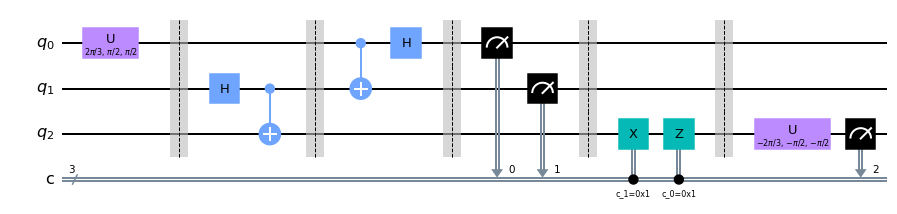

In [5]:
# This example prepares the state of the sender by using an unitary operation.
# The recipient performs an inverted operation of the unitary operation to the teleported state.
# Therefore, the state of the recipient becomes |0> if the teleportation finishes successfully.
qc = teleport_qc(0.25, measure_flag=True)
qc.draw(output="mpl")

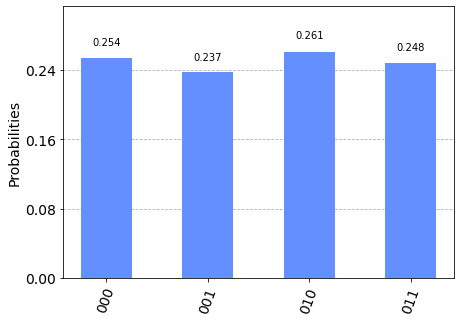

In [6]:
# The sender measures the two qubits and obtains one of four possible classical results. (00, 01, 10 and 11)
# In any case of results, the recipient get the state |0> (= q2).
# As a result, the teleportation successfully moves the state from the sender to the recipient.
aer_sim = Aer.get_backend("aer_simulator")
job = aer_sim.run(assemble(qc), shots=4096)
result = job.result().get_counts()
plot_histogram(result)

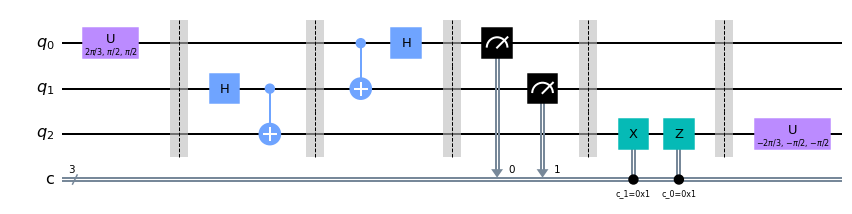

In [7]:
# Another simulation.
# This example calculates the density matrix of the state.
# To calculate the density matrix, the recipient skips the measurement of the state.
qc = teleport_qc(0.25, measure_flag=False)
qc.draw(output="mpl")

In [8]:
sv_simulator = Aer.get_backend('statevector_simulator')
circuit = transpile(qc, backend=sv_simulator)
res = []
for i in range(1024):
    statevector = sv_simulator.run(circuit).result().data()['statevector']
    res.append(statevector)

In [9]:
# In the case that q1 is |0> and q0 is |0>.
# p ~ 0.25.
# The recipient gets |0> (= q2).
statevec_mean_cond_sample(res, [None, 0, 0])

(0.265625,
 Operator([[ 1.00000000e+00+0.00000000e+00j,
            -5.30287619e-17-2.22044605e-16j],
           [-5.30287619e-17+2.22044605e-16j,
             5.21158562e-32+0.00000000e+00j]],
          input_dims=(2,), output_dims=(2,)))

In [10]:
# In the case that q1 is |0> and q0 is |1>.
# p ~ 0.25.
# The recipient gets |0> (= q2).
statevec_mean_cond_sample(res, [None, 0, 1])

(0.2509765625,
 Operator([[ 1.00000000e+00+0.00000000e+00j,
            -5.30287619e-17-5.55111512e-17j],
           [-5.30287619e-17+5.55111512e-17j,
             5.89353750e-33+0.00000000e+00j]],
          input_dims=(2,), output_dims=(2,)))

In [11]:
# In the case that q1 is |1> and q0 is |0>.
# p ~ 0.25.
# The recipient gets |0> (= q2).
statevec_mean_cond_sample(res, [None, 1, 0])

(0.2275390625,
 Operator([[ 1.00000000e+00+0.00000000e+00j,
            -5.30287619e-17-5.55111512e-17j],
           [-5.30287619e-17+5.55111512e-17j,
             5.89353750e-33+0.00000000e+00j]],
          input_dims=(2,), output_dims=(2,)))

In [12]:
# In the case that q1 is |1> and q1 is |1>.
# p ~ 0.25.
# The recipient gets |0> (= q2).
statevec_mean_cond_sample(res, [None, 1, 1])

(0.255859375,
 Operator([[ 1.00000000e+00+0.00000000e+00j,
            -5.30287619e-17+5.55111512e-17j],
           [-5.30287619e-17-5.55111512e-17j,
             5.89353750e-33+0.00000000e+00j]],
          input_dims=(2,), output_dims=(2,)))